# Paths

In [1]:
dataset_path = "./datasets/ASDID"
tensorboard_path = "logs/"
models_path = "./models/ASDID/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [4]:
from torchvision.models import resnet101, ResNet101_Weights
my_transform = ResNet101_Weights.IMAGENET1K_V1.transforms()

In [5]:
import torch
import torchvision

data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 128

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

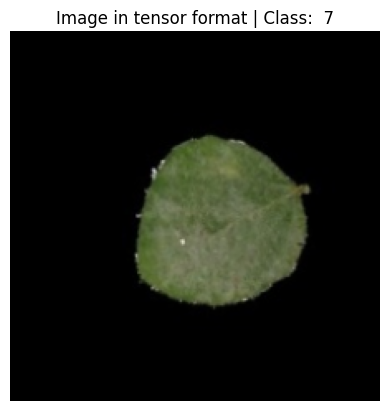

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

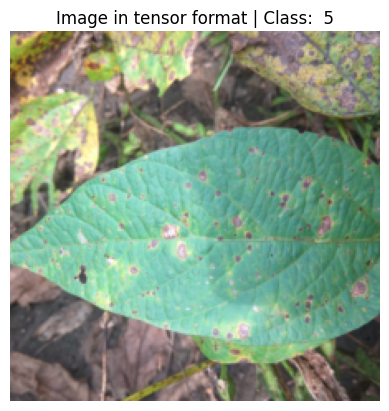

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [8]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break


    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}ResNet101-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [9]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [10]:
import torch
from torchvision.models import resnet101

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet101-SoyNet-95.98.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [12]:
for param in modelResNetTL.parameters():
    param.requires_grad = False

modelResNetTL.fc.requires_grad_(True)
# num_classes = 10
num_classes = 13
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

Running on cuda
Labels: tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Training epochs...:   1%|          | 1/100 [01:39<2:44:25, 99.65s/it]

Saving Best Model with Accuracy:  9.401709401709402
Epoch:   1 | Accuracy :  9.4017%


Training epochs...:   2%|▏         | 2/100 [03:20<2:44:02, 100.44s/it]

Saving Best Model with Accuracy:  14.52991452991453
Epoch:   2 | Accuracy : 14.5299%


Training epochs...:   3%|▎         | 3/100 [05:01<2:42:29, 100.51s/it]

Saving Best Model with Accuracy:  23.076923076923077
Epoch:   3 | Accuracy : 23.0769%


Training epochs...:   4%|▍         | 4/100 [06:41<2:40:30, 100.32s/it]

Saving Best Model with Accuracy:  27.92022792022792
Epoch:   4 | Accuracy : 27.9202%


Training epochs...:   5%|▌         | 5/100 [08:15<2:35:05, 97.95s/it] 

Saving Best Model with Accuracy:  32.193732193732195
Epoch:   5 | Accuracy : 32.1937%


Training epochs...:   6%|▌         | 6/100 [09:47<2:30:17, 95.93s/it]

Saving Best Model with Accuracy:  33.04843304843305
Epoch:   6 | Accuracy : 33.0484%


Training epochs...:   7%|▋         | 7/100 [11:15<2:24:51, 93.46s/it]

Saving Best Model with Accuracy:  36.75213675213675
Epoch:   7 | Accuracy : 36.7521%


Training epochs...:   8%|▊         | 8/100 [12:46<2:22:07, 92.69s/it]

Saving Best Model with Accuracy:  37.89173789173789
Epoch:   8 | Accuracy : 37.8917%


Training epochs...:   9%|▉         | 9/100 [14:17<2:19:36, 92.05s/it]

Saving Best Model with Accuracy:  39.31623931623932
Epoch:   9 | Accuracy : 39.3162%


Training epochs...:  10%|█         | 10/100 [15:48<2:17:33, 91.70s/it]

Saving Best Model with Accuracy:  43.01994301994302
Epoch:  10 | Accuracy : 43.0199%


Training epochs...:  11%|█         | 11/100 [17:20<2:16:27, 91.99s/it]

Saving Best Model with Accuracy:  45.2991452991453
Epoch:  11 | Accuracy : 45.2991%


Training epochs...:  12%|█▏        | 12/100 [18:53<2:15:12, 92.19s/it]

Saving Best Model with Accuracy:  46.43874643874644
Epoch:  12 | Accuracy : 46.4387%


Training epochs...:  13%|█▎        | 13/100 [20:23<2:12:56, 91.68s/it]

Saving Best Model with Accuracy:  48.148148148148145
Epoch:  13 | Accuracy : 48.1481%


Training epochs...:  14%|█▍        | 14/100 [21:57<2:12:18, 92.31s/it]

Saving Best Model with Accuracy:  49.857549857549856
Epoch:  14 | Accuracy : 49.8575%


Training epochs...:  15%|█▌        | 15/100 [23:29<2:10:24, 92.06s/it]

Epoch:  15 | Accuracy : 49.8575%


Training epochs...:  16%|█▌        | 16/100 [24:59<2:08:06, 91.51s/it]

Saving Best Model with Accuracy:  52.421652421652425
Epoch:  16 | Accuracy : 52.4217%


Training epochs...:  17%|█▋        | 17/100 [26:30<2:06:36, 91.53s/it]

Saving Best Model with Accuracy:  52.99145299145299
Epoch:  17 | Accuracy : 52.9915%


Training epochs...:  18%|█▊        | 18/100 [27:58<2:03:29, 90.35s/it]

Saving Best Model with Accuracy:  53.56125356125356
Epoch:  18 | Accuracy : 53.5613%


Training epochs...:  19%|█▉        | 19/100 [29:31<2:03:07, 91.21s/it]

Saving Best Model with Accuracy:  56.6951566951567
Epoch:  19 | Accuracy : 56.6952%


Training epochs...:  20%|██        | 20/100 [31:03<2:01:59, 91.50s/it]

Saving Best Model with Accuracy:  57.26495726495727
Epoch:  20 | Accuracy : 57.2650%


Training epochs...:  21%|██        | 21/100 [32:36<2:01:05, 91.96s/it]

Saving Best Model with Accuracy:  58.68945868945869
Epoch:  21 | Accuracy : 58.6895%


Training epochs...:  22%|██▏       | 22/100 [34:05<1:58:17, 90.99s/it]

Saving Best Model with Accuracy:  58.97435897435897
Epoch:  22 | Accuracy : 58.9744%


Training epochs...:  23%|██▎       | 23/100 [35:36<1:56:52, 91.07s/it]

Epoch:  23 | Accuracy : 58.9744%


Training epochs...:  24%|██▍       | 24/100 [37:09<1:55:53, 91.49s/it]

Saving Best Model with Accuracy:  60.3988603988604
Epoch:  24 | Accuracy : 60.3989%


Training epochs...:  25%|██▌       | 25/100 [38:39<1:53:50, 91.08s/it]

Epoch:  25 | Accuracy : 59.5442%


Training epochs...:  26%|██▌       | 26/100 [40:08<1:51:26, 90.35s/it]

Epoch:  26 | Accuracy : 60.3989%


Training epochs...:  27%|██▋       | 27/100 [41:35<1:48:41, 89.33s/it]

Saving Best Model with Accuracy:  61.25356125356125
Epoch:  27 | Accuracy : 61.2536%


Training epochs...:  28%|██▊       | 28/100 [43:04<1:47:06, 89.26s/it]

Saving Best Model with Accuracy:  61.82336182336182
Epoch:  28 | Accuracy : 61.8234%


Training epochs...:  29%|██▉       | 29/100 [44:34<1:45:51, 89.46s/it]

Saving Best Model with Accuracy:  63.81766381766382
Epoch:  29 | Accuracy : 63.8177%


Training epochs...:  30%|███       | 30/100 [46:00<1:43:28, 88.69s/it]

Epoch:  30 | Accuracy : 63.8177%


Training epochs...:  31%|███       | 31/100 [47:24<1:40:09, 87.09s/it]

Saving Best Model with Accuracy:  64.67236467236468
Epoch:  31 | Accuracy : 64.6724%


Training epochs...:  32%|███▏      | 32/100 [48:48<1:37:41, 86.20s/it]

Saving Best Model with Accuracy:  65.24216524216524
Epoch:  32 | Accuracy : 65.2422%


Training epochs...:  33%|███▎      | 33/100 [50:12<1:35:28, 85.50s/it]

Saving Best Model with Accuracy:  65.52706552706553
Epoch:  33 | Accuracy : 65.5271%


Training epochs...:  34%|███▍      | 34/100 [51:35<1:33:26, 84.94s/it]

Saving Best Model with Accuracy:  66.95156695156695
Epoch:  34 | Accuracy : 66.9516%


Training epochs...:  35%|███▌      | 35/100 [53:02<1:32:25, 85.32s/it]

Epoch:  35 | Accuracy : 66.6667%


Training epochs...:  36%|███▌      | 36/100 [54:29<1:31:36, 85.88s/it]

Epoch:  36 | Accuracy : 66.9516%


Training epochs...:  37%|███▋      | 37/100 [55:56<1:30:42, 86.38s/it]

Epoch:  37 | Accuracy : 66.3818%


Training epochs...:  38%|███▊      | 38/100 [57:22<1:29:00, 86.14s/it]

Epoch:  38 | Accuracy : 66.9516%


Training epochs...:  39%|███▉      | 39/100 [58:49<1:27:42, 86.28s/it]

Epoch:  39 | Accuracy : 66.6667%


Training epochs...:  40%|████      | 40/100 [1:00:12<1:25:21, 85.37s/it]

Saving Best Model with Accuracy:  67.23646723646723
Epoch:  40 | Accuracy : 67.2365%


Training epochs...:  41%|████      | 41/100 [1:01:34<1:22:57, 84.36s/it]

Epoch:  41 | Accuracy : 67.2365%


Training epochs...:  42%|████▏     | 42/100 [1:02:57<1:21:10, 83.97s/it]

Saving Best Model with Accuracy:  68.66096866096866
Epoch:  42 | Accuracy : 68.6610%


Training epochs...:  43%|████▎     | 43/100 [1:04:22<1:20:09, 84.37s/it]

Epoch:  43 | Accuracy : 68.6610%


Training epochs...:  44%|████▍     | 44/100 [1:05:50<1:19:41, 85.39s/it]

Epoch:  44 | Accuracy : 68.6610%


Training epochs...:  45%|████▌     | 45/100 [1:07:13<1:17:43, 84.80s/it]

Epoch:  45 | Accuracy : 68.6610%


Training epochs...:  46%|████▌     | 46/100 [1:08:35<1:15:29, 83.88s/it]

Epoch:  46 | Accuracy : 68.6610%


Training epochs...:  47%|████▋     | 47/100 [1:09:58<1:13:49, 83.58s/it]

Saving Best Model with Accuracy:  69.51566951566952
Epoch:  47 | Accuracy : 69.5157%


Training epochs...:  48%|████▊     | 48/100 [1:11:25<1:13:23, 84.68s/it]

Saving Best Model with Accuracy:  70.08547008547009
Epoch:  48 | Accuracy : 70.0855%


Training epochs...:  49%|████▉     | 49/100 [1:12:49<1:11:51, 84.54s/it]

Saving Best Model with Accuracy:  70.37037037037037
Epoch:  49 | Accuracy : 70.3704%


Training epochs...:  50%|█████     | 50/100 [1:14:13<1:10:10, 84.22s/it]

Epoch:  50 | Accuracy : 69.2308%


Training epochs...:  51%|█████     | 51/100 [1:15:38<1:08:55, 84.40s/it]

Epoch:  51 | Accuracy : 69.2308%


Training epochs...:  52%|█████▏    | 52/100 [1:17:04<1:08:03, 85.06s/it]

Epoch:  52 | Accuracy : 69.8006%


Training epochs...:  53%|█████▎    | 53/100 [1:18:28<1:06:12, 84.52s/it]

Epoch:  53 | Accuracy : 70.3704%


Training epochs...:  54%|█████▍    | 54/100 [1:19:52<1:04:50, 84.58s/it]

Epoch:  54 | Accuracy : 69.8006%


Training epochs...:  55%|█████▌    | 55/100 [1:21:20<1:04:04, 85.43s/it]

Epoch:  55 | Accuracy : 70.0855%


Training epochs...:  56%|█████▌    | 56/100 [1:22:48<1:03:14, 86.23s/it]

Epoch:  56 | Accuracy : 70.3704%


Training epochs...:  57%|█████▋    | 57/100 [1:24:16<1:02:12, 86.79s/it]

Epoch:  57 | Accuracy : 70.3704%


Training epochs...:  58%|█████▊    | 58/100 [1:25:43<1:00:46, 86.82s/it]

Saving Best Model with Accuracy:  70.94017094017094
Epoch:  58 | Accuracy : 70.9402%


Training epochs...:  59%|█████▉    | 59/100 [1:27:12<59:44, 87.41s/it]  

Epoch:  59 | Accuracy : 70.3704%


Training epochs...:  60%|██████    | 60/100 [1:28:39<58:16, 87.41s/it]

Epoch:  60 | Accuracy : 70.6553%


Training epochs...:  61%|██████    | 61/100 [1:30:03<56:10, 86.42s/it]

Epoch:  61 | Accuracy : 70.9402%


Training epochs...:  62%|██████▏   | 62/100 [1:31:26<54:06, 85.44s/it]

Saving Best Model with Accuracy:  71.22507122507122
Epoch:  62 | Accuracy : 71.2251%


Training epochs...:  63%|██████▎   | 63/100 [1:32:50<52:17, 84.80s/it]

Epoch:  63 | Accuracy : 71.2251%


Training epochs...:  64%|██████▍   | 64/100 [1:34:13<50:39, 84.43s/it]

Saving Best Model with Accuracy:  71.5099715099715
Epoch:  64 | Accuracy : 71.5100%


Training epochs...:  65%|██████▌   | 65/100 [1:35:37<49:04, 84.12s/it]

Saving Best Model with Accuracy:  71.7948717948718
Epoch:  65 | Accuracy : 71.7949%


Training epochs...:  66%|██████▌   | 66/100 [1:37:00<47:33, 83.94s/it]

Saving Best Model with Accuracy:  72.07977207977208
Epoch:  66 | Accuracy : 72.0798%


Training epochs...:  67%|██████▋   | 67/100 [1:38:23<46:00, 83.64s/it]

Saving Best Model with Accuracy:  72.64957264957265
Epoch:  67 | Accuracy : 72.6496%


Training epochs...:  68%|██████▊   | 68/100 [1:39:46<44:35, 83.60s/it]

Epoch:  68 | Accuracy : 72.3647%


Training epochs...:  69%|██████▉   | 69/100 [1:41:11<43:24, 84.02s/it]

Epoch:  69 | Accuracy : 72.3647%


Training epochs...:  70%|███████   | 70/100 [1:42:39<42:36, 85.21s/it]

Epoch:  70 | Accuracy : 72.6496%


Training epochs...:  71%|███████   | 71/100 [1:44:07<41:26, 85.75s/it]

Saving Best Model with Accuracy:  73.21937321937322
Epoch:  71 | Accuracy : 73.2194%


Training epochs...:  72%|███████▏  | 72/100 [1:45:28<39:29, 84.63s/it]

Epoch:  72 | Accuracy : 73.2194%


Training epochs...:  73%|███████▎  | 73/100 [1:46:49<37:34, 83.49s/it]

Epoch:  73 | Accuracy : 73.2194%


Training epochs...:  74%|███████▍  | 74/100 [1:48:12<36:02, 83.16s/it]

Epoch:  74 | Accuracy : 72.0798%


Training epochs...:  75%|███████▌  | 75/100 [1:49:36<34:43, 83.34s/it]

Epoch:  75 | Accuracy : 72.3647%


Training epochs...:  76%|███████▌  | 76/100 [1:51:02<33:39, 84.16s/it]

Epoch:  76 | Accuracy : 72.9345%


Training epochs...:  77%|███████▋  | 77/100 [1:52:24<32:04, 83.66s/it]

Saving Best Model with Accuracy:  74.07407407407408
Epoch:  77 | Accuracy : 74.0741%


Training epochs...:  78%|███████▊  | 78/100 [1:53:48<30:41, 83.72s/it]

Epoch:  78 | Accuracy : 73.7892%


Training epochs...:  79%|███████▉  | 79/100 [1:55:12<29:17, 83.70s/it]

Epoch:  79 | Accuracy : 74.0741%


Training epochs...:  80%|████████  | 80/100 [1:56:35<27:53, 83.68s/it]

Epoch:  80 | Accuracy : 73.7892%


Training epochs...:  81%|████████  | 81/100 [1:57:59<26:32, 83.79s/it]

Epoch:  81 | Accuracy : 73.5043%


Training epochs...:  82%|████████▏ | 82/100 [1:59:23<25:08, 83.78s/it]

Saving Best Model with Accuracy:  74.35897435897436
Epoch:  82 | Accuracy : 74.3590%


Training epochs...:  83%|████████▎ | 83/100 [2:00:47<23:43, 83.76s/it]

Epoch:  83 | Accuracy : 73.7892%


Training epochs...:  84%|████████▍ | 84/100 [2:02:10<22:17, 83.62s/it]

Epoch:  84 | Accuracy : 72.9345%


Training epochs...:  85%|████████▌ | 85/100 [2:03:34<20:56, 83.74s/it]

Epoch:  85 | Accuracy : 74.3590%


Training epochs...:  86%|████████▌ | 86/100 [2:04:58<19:32, 83.74s/it]

Epoch:  86 | Accuracy : 74.3590%


Training epochs...:  87%|████████▋ | 87/100 [2:06:22<18:09, 83.78s/it]

Saving Best Model with Accuracy:  75.21367521367522
Epoch:  87 | Accuracy : 75.2137%


Training epochs...:  88%|████████▊ | 88/100 [2:07:45<16:43, 83.66s/it]

Epoch:  88 | Accuracy : 74.6439%


Training epochs...:  89%|████████▉ | 89/100 [2:09:08<15:16, 83.33s/it]

Epoch:  89 | Accuracy : 74.3590%


Training epochs...:  90%|█████████ | 90/100 [2:10:28<13:45, 82.52s/it]

Epoch:  90 | Accuracy : 74.6439%


Training epochs...:  91%|█████████ | 91/100 [2:11:49<12:19, 82.11s/it]

Epoch:  91 | Accuracy : 74.9288%


Training epochs...:  92%|█████████▏| 92/100 [2:13:11<10:55, 82.00s/it]

Epoch:  92 | Accuracy : 74.3590%


Training epochs...:  93%|█████████▎| 93/100 [2:14:36<09:39, 82.75s/it]

Epoch:  93 | Accuracy : 74.0741%


Training epochs...:  94%|█████████▍| 94/100 [2:16:02<08:22, 83.75s/it]

Epoch:  94 | Accuracy : 74.0741%


Training epochs...:  95%|█████████▌| 95/100 [2:17:26<06:58, 83.77s/it]

Epoch:  95 | Accuracy : 74.6439%


Training epochs...:  96%|█████████▌| 96/100 [2:18:50<05:35, 83.92s/it]

Epoch:  96 | Accuracy : 74.9288%


Training epochs...:  97%|█████████▋| 97/100 [2:20:15<04:13, 84.40s/it]

Epoch:  97 | Accuracy : 74.6439%


Training epochs...:  98%|█████████▊| 98/100 [2:21:39<02:48, 84.23s/it]

Epoch:  98 | Accuracy : 74.9288%


Training epochs...:  99%|█████████▉| 99/100 [2:23:05<01:24, 84.65s/it]

Epoch:  99 | Accuracy : 74.6439%


Training epochs...: 100%|██████████| 100/100 [2:24:30<00:00, 86.70s/it]

Epoch: 100 | Accuracy : 74.6439%
Model saved in: ./models/SoyBean/ResNet101-SoyBean-75.21.pkl


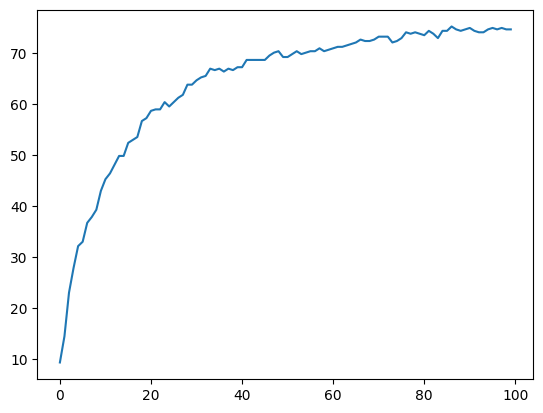

In [14]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-3
dataset = 'SoyBean'
prefix = 'ResNet101-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 300
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
2
Predicted: crestamento | Corrected: crestamento | Confidence: 41.71%


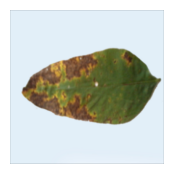

In [15]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "BacterialBlight", "CercosporaLeafBlight", "DowneyMildew", "Frogeye", "Healthy", "PotassiumDeficiency",
        "SoybeanRust", "TargetSpot", "UnusedCercosporaLeafBlight", "UnusedHealthy", "UnusedSoybeanRust"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
